# Бинарный классификатор (два класса либо "да/нет")

In [1]:
#1
#classes = ('plane', 'car', 'bird', 'cat',
#           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
catclass = 3

import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # x -> (x-mean)/std, преобразует  [0,1] -> [-1,1]

#модифицируем метки в датасете: кот=1, не кот=0
target_transform = transforms.Lambda(lambda y: torch.tensor([1.0]) if y==catclass else torch.tensor([0.0]) ) 


batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./cifar10data', train=True,
                                        download=True, transform=transform, target_transform = target_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./cifar10data', train=False,
                                       download=True, transform=transform, target_transform = target_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
#2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.sigm = torch.nn.Sigmoid()

    def forward(self, x):                  
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.sigm(self.fc3(x))
        return x

In [3]:
#3
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

netGPU = Net()
netGPU.to(device)

#criterion = nn.CrossEntropyLoss() #заменим кроссэнтропию на бинарную
criterion = nn.BCELoss()
optimizerGPU = optim.SGD(netGPU.parameters(), lr=0.001, momentum=0.9)
PATH = './cifar_net2.pth'

cuda:1


In [4]:
#4 не запускайте тренировку на занятии
import time
start = time.time()

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        #print (labels)
        # zero the parameter gradients
        optimizerGPU.zero_grad()

        # forward + backward + optimize
        outputs = netGPU(inputs)
        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizerGPU.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

finish = time.time()
print('Finished Training in ', finish-start)
torch.save(netGPU.state_dict(), PATH)

[1,  1000] loss: 0.181
[1,  2000] loss: 0.148
[1,  3000] loss: 0.150
[2,  1000] loss: 0.142
[2,  2000] loss: 0.143
[2,  3000] loss: 0.139
[3,  1000] loss: 0.136
[3,  2000] loss: 0.137
[3,  3000] loss: 0.135
[4,  1000] loss: 0.134
[4,  2000] loss: 0.135
[4,  3000] loss: 0.129
[5,  1000] loss: 0.133
[5,  2000] loss: 0.127
[5,  3000] loss: 0.128
[6,  1000] loss: 0.124
[6,  2000] loss: 0.130
[6,  3000] loss: 0.126
[7,  1000] loss: 0.123
[7,  2000] loss: 0.128
[7,  3000] loss: 0.125
[8,  1000] loss: 0.126
[8,  2000] loss: 0.122
[8,  3000] loss: 0.122
[9,  1000] loss: 0.119
[9,  2000] loss: 0.123
[9,  3000] loss: 0.120
[10,  1000] loss: 0.120
[10,  2000] loss: 0.121
[10,  3000] loss: 0.119
[11,  1000] loss: 0.119
[11,  2000] loss: 0.119
[11,  3000] loss: 0.117
[12,  1000] loss: 0.117
[12,  2000] loss: 0.117
[12,  3000] loss: 0.116
[13,  1000] loss: 0.114
[13,  2000] loss: 0.117
[13,  3000] loss: 0.114
[14,  1000] loss: 0.114
[14,  2000] loss: 0.115
[14,  3000] loss: 0.110
[15,  1000] loss: 0

In [5]:
#5
netGPU.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [5]:
#6
import numpy as np

truth = np.array([])
preds = np.array([])

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images = data[0].to(device)
        
        outputs = netGPU(images)        
        truth = np.concatenate((truth, data[1].numpy().flatten()))
        preds = np.concatenate((preds, outputs.to('cpu').numpy().flatten()))

print(truth[:20])
print(preds[:20]) 

[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[3.71057093e-01 1.21266339e-06 1.62905362e-03 4.78375284e-03
 7.49083236e-02 1.33338151e-02 9.23358575e-02 1.04048178e-02
 3.50498796e-01 8.33247788e-04 1.22145861e-02 4.92002757e-04
 3.92753705e-02 1.26949788e-04 1.08439685e-03 2.49247421e-02
 1.56681687e-01 8.07938427e-02 3.41094012e-04 2.94868066e-03]


In [17]:
#7
level = 0.3
preds01 = map( lambda x: 1. if x>level else 0. , preds)
preds01 = np.array(list(preds01))
print(preds01[:20]) 

[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [25]:
#8
def classify(level, preds, truth):
    preds01 = map( lambda x: 1. if x>level else 0. , preds)
    preds01 = np.array(list(preds01))

    total_cat_predictions = np.sum(preds01)
    total_nocat_predictions = len(preds01)-total_cat_predictions

    true_cats = np.sum(truth)
    true_nocats = len(truth)-true_cats

    correct_cat_predictions = np.sum(preds01*truth)
    incorrect_cat_predictions = total_cat_predictions - correct_cat_predictions

    correct_nocat_predictions = np.sum( (np.ones(preds01.shape[0],dtype=int) - preds01) * (np.ones(truth.shape[0],dtype=int)-truth) )
    incorrect_nocat_predictions = total_nocat_predictions - correct_nocat_predictions

    print(f"Всего картинок в датасете: {truth.shape[0]}")
    print(f"Всего котов в датасете (P): {true_cats}, всего картинок без котов (N): {true_nocats}")
    print(f"Предсказано котов (PP): {total_cat_predictions}, предсказано, что нет кота (PN): {total_nocat_predictions}")
    print(f"Верные предсказания котов (TP): {correct_cat_predictions}, неверные предсказания котов (FP): {incorrect_cat_predictions}")
    print(f"Верные предсказания отсутствия кота (TN): {correct_nocat_predictions}, неверные предсказания отсутствия кота (FN): {incorrect_nocat_predictions}")
    return preds01

In [45]:
#9
preds01 = classify(0.25, preds, truth)

Всего картинок в датасете: 10000
Всего котов в датасете (P): 1000.0, всего картинок без котов (N): 9000.0
Предсказано котов (PP): 1195.0, предсказано, что нет кота (PN): 8805.0
Верные предсказания котов (TP): 508.0, неверные предсказания котов (FP): 687.0
Верные предсказания отсутствия кота (TN): 8313.0, неверные предсказания отсутствия кота (FN): 492.0


# Используем scikit-learn для визуализации

              precision    recall  f1-score   support

    нет кота       0.94      0.92      0.93      9000
         кот       0.43      0.51      0.46      1000

    accuracy                           0.88     10000
   macro avg       0.68      0.72      0.70     10000
weighted avg       0.89      0.88      0.89     10000



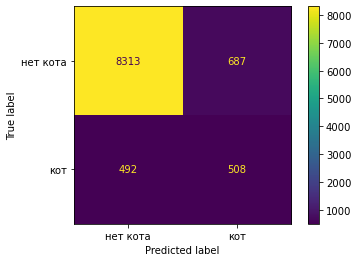

In [46]:
#10
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(truth, preds01)
cm_display = ConfusionMatrixDisplay(cm, display_labels=["нет кота", "кот"]).plot()

В общем случае:

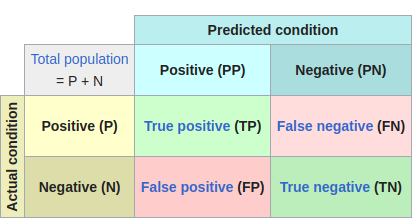

# Метрики качества предиктора с фиксированным пороговым значением

1. True positive rate,  $TPR = \frac{TP}{P} = \frac{TP}{TP+FN}$

 Частота истинно положительных. Другие названия: recall, sensitivity (чувствительность). Доля верно предсказанных котов среди всех котов датасета.
 
2. True negative rate, $TNR = \frac{TN}{N} = \frac{TN}{FP+TN}$

 Частота истинно отрицательных. Другие названия: specificity (специфичность). Доля верно предсказанных не-котов среди всех не-котов датасета.
 
3. Positive predictive value $PPV = \frac{TP}{PP} = \frac{TP}{TP+FP}$

 Положительное предсказательное значение. Другие названия: precision. Доля верно предсказанных котов среди всех предсказанных котов.
 
4. False discovery rate $FDR = \frac{FP}{PP} = \frac{FP}{TP+FP}$

 Частота ошибочных обнаружений. Доля неверно предсказанных котов среди всех предсказанных котов.
 
5. Accuracy, $Acc = \frac{TP+TN}{PP+PN} = \frac{TP+TN}{TP+FP+TN+FN}$

 Точность, доля верных предсказаний среди всех предсказаний.
 
6. F1-score, $F_1 = 2 \frac{TPR * PPV}{TPR + PPV}$

 Гармоническое среднее precision и recall

In [47]:
#11
from sklearn.metrics import classification_report
print(classification_report(truth, preds01, target_names=["нет кота", "кот"]))

              precision    recall  f1-score   support

    нет кота       0.94      0.92      0.93      9000
         кот       0.43      0.51      0.46      1000

    accuracy                           0.88     10000
   macro avg       0.68      0.72      0.70     10000
weighted avg       0.89      0.88      0.89     10000



# Зависимость метрик от порогового значения

[1.0, 0.747, 0.587, 0.441, 0.326, 0.212, 0.119, 0.049, 0.003, 0.0]


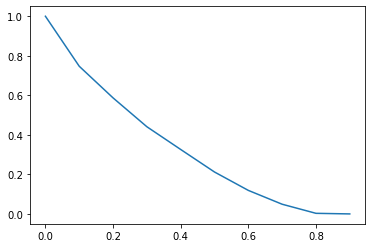

In [34]:
#12
import matplotlib.pyplot as plt

def get_recall(preds, labels):
    P = np.sum(labels)
    TP = np.sum(preds*labels)
    return TP/P


levels = np.arange(0, 1, 0.1)
recalls = []

for level in levels:    
    preds01 = map( lambda x: 1. if x>level else 0. , preds)
    preds01 = np.array(list(preds01))
    recalls.append(get_recall(preds01, truth))
    
print(recalls) 
plt.plot(levels, recalls)

Упражнение: найдите зависимость precision от порога и изобразите зависимости precision и recall от порога на одном графике.

# Параметрические кривые для пар метрик, интегральные метрики

## 1. Precision-Recall

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html

0.4395609987773193


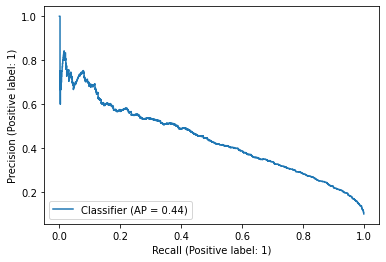

In [36]:
#13
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score
print(average_precision_score(truth, preds))
PrecisionRecallDisplay.from_predictions(truth, preds)

Average precision:

$\text{AP} = \sum_n (R_n - R_{n-1}) P_n$

Упрощенный вариант

AP= 0.8333333333333333


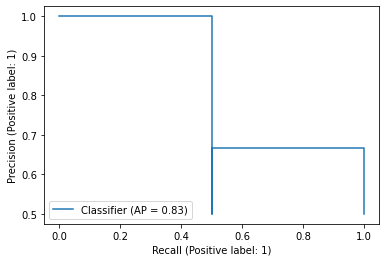

In [48]:
#14
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
print("AP=",average_precision_score(y_true, y_scores))
PrecisionRecallDisplay.from_predictions(y_true, y_scores)

Начнем с очень требовательного уровня и закончим самым нетребовательным

| Level             | Обнаружений | Верных   | Recall | Precision | 
| :---------------- | :------:    | :------: | ----:  | :------:  | 
| 1 - 0.8           | 0           | 0        |      0 | 1         |
| 0.8 - 0.4         | 1           | 1        |    0.5 | 1         |
| 0.4 - 0.35        | 2           | 1        |    0.5 | 0.5       |
| 0.35 - 0.1        | 3           | 2        |      1 | 0.66      |
| 0.1 - 0           | 4           | 2        |      1 | 0.5       |





## 2. ROC-кривая (Receiver operating characteristics)

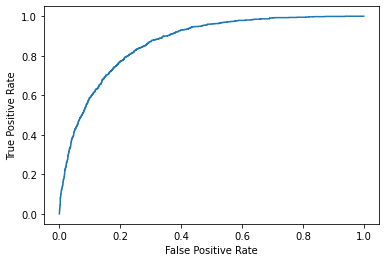

In [40]:
#15
from sklearn.metrics import RocCurveDisplay, roc_curve
fpr, tpr, _ = roc_curve(truth, preds)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

Area Under Curve

In [42]:
#16
from sklearn.metrics import roc_auc_score
roc_auc_score(truth, preds)

0.8682621111111113

# Матрица ошибок многоисходного классификатора

In [49]:
#17
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # x -> (x-mean)/std, преобразует  [0,1] -> [-1,1]

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./cifar10data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./cifar10data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [50]:
#18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, dbg=False):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dbg = dbg

    def forward(self, x):
        if self.dbg:
            insize = x.size()            
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        if self.dbg:
            outsize = x.size()
            print("\tIn Model: input size", insize, "output size", outsize)
        return x

In [52]:
#19
netGPU = Net()
netGPU.to(device)

criterion = nn.CrossEntropyLoss()
optimizerGPU = optim.SGD(netGPU.parameters(), lr=0.001, momentum=0.9)

In [55]:
#20
import time
from tqdm import tqdm

start = time.time()
epochs = 20

for epoch in tqdm(range(1, 1+epochs)):  # loop over the dataset multiple times
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizerGPU.zero_grad()

        # forward + backward + optimize
        outputs = netGPU(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizerGPU.step()

finish = time.time()
print('Finished Training in ', finish-start)

torch.save(netGPU.state_dict(), './cifar_net.pth')

100%|██████████| 20/20 [07:05<00:00, 21.26s/it]

Finished Training in  425.30013942718506


In [56]:
#21
netGPU.load_state_dict(torch.load('./cifar_net.pth'))

<All keys matched successfully>

In [57]:
#22 соберем предсказания в массив
import numpy as np

truth = np.array([])
preds = np.array([])

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images = data[0].to(device)
        
        outputs = netGPU(images)        
        
        _, predicted = torch.max(outputs.data, 1)
        
        truth = np.concatenate((truth, data[1].numpy().flatten()))
        preds = np.concatenate((preds, predicted.to('cpu').numpy().flatten()))

print(truth[:20])
print(preds[:20]) 

[3. 8. 8. 0. 6. 6. 1. 6. 3. 1. 0. 9. 5. 7. 9. 8. 5. 7. 8. 6.]
[3. 8. 1. 8. 3. 6. 9. 4. 5. 1. 0. 9. 5. 7. 9. 9. 5. 3. 8. 7.]


              precision    recall  f1-score   support

       plane       0.53      0.54      0.54      1000
         car       0.67      0.54      0.60      1000
        bird       0.39      0.22      0.28      1000
         cat       0.29      0.27      0.28      1000
        deer       0.41      0.32      0.36      1000
         dog       0.38      0.50      0.43      1000
        frog       0.54      0.42      0.48      1000
       horse       0.44      0.62      0.52      1000
        ship       0.55      0.59      0.57      1000
       truck       0.47      0.64      0.54      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.46     10000
weighted avg       0.47      0.47      0.46     10000



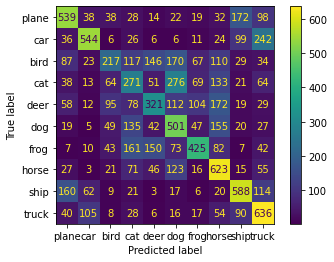

In [60]:
#23
cm = confusion_matrix(truth, preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']).plot()
print(classification_report(truth, preds, target_names=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']))

# mAP - mean average precision

In [ ]:
#не работает в текущей версии (1.1.1), добавлено позднее (но смысл понятен)
import numpy as np
from sklearn.metrics import average_precision_score
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
average_precision_score(y_true, y_scores)
y_true = np.array([0, 0, 1, 1, 2, 2])
y_scores = np.array([
    [0.7, 0.2, 0.1],
    [0.4, 0.3, 0.3],
    [0.1, 0.8, 0.1],
    [0.2, 0.3, 0.5],
    [0.4, 0.4, 0.2],
    [0.1, 0.2, 0.7],
])
average_precision_score(y_true, y_scores)

Упражнение: используйте функцию softmax и получите для каждой тестовой картинки вектор из вероятностей принадлежности к каждому классу

Упражнение: по полученным векторам из вероятностей вычислите AP для каждого класса и найдите среднее (макро).